# Projekt 1 - Analiza ryzyka kredytowego
## Pipeline preprocessing dla modeli interpretowalnych

**Cel:** Przygotowanie danych pod interpretowalny model predykcyjny z możliwością odwrócenia transformacji

**Kluczowe cechy:**
- ✅ Tylko transformacje odwracalne (Box-Cox, Yeo-Johnson, log1p)
- ✅ Brak transformacji kwantylowych niszczących interpretowalność
- ✅ Możliwość inverse_transform dla każdej cechy
- ✅ Gotowe do analizy SHAP/LIME

### Import bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, chi2_contingency
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import chi2
import warnings

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
pd.options.mode.copy_on_write = True
plt.style.use('seaborn-v0_8')

### Wczytanie danych

In [2]:
df = pd.read_csv("zbior_10.csv")
print(f"Wymiary danych: {df.shape}")
print(f"Procent klasy pozytywnej (default=1): {100*df['default'].sum()/len(df):.2f}%")

Wymiary danych: (3000, 220)
Procent klasy pozytywnej (default=1): 6.10%


### Podział na zbiór treningowy i testowy

In [3]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1)
X_train = df_train.drop("default", axis=1)
y_train = df_train["default"]
X_test = df_test.drop("default", axis=1)
y_test = df_test["default"]

print(f"Zbiór treningowy: {X_train.shape}")
print(f"Zbiór testowy: {X_test.shape}")

Zbiór treningowy: (2100, 219)
Zbiór testowy: (900, 219)


## Definicja funkcji preprocessing

### 1. Funkcja identyfikacji kolumn do usunięcia

In [4]:
def identify_columns_to_drop(X, y=None, missing_threshold=0.0):
    """
    Identyfikuje kolumny do usunięcia:
    - kolumny z brakami danych
    - kolumny kategoryczne (typu object)
    - kolumny z małą liczbą unikalnych wartości (<=10)
    - kolumny ze stałą wartością
    
    Parametry:
    ----------
    X : pd.DataFrame
        Dane wejściowe
    y : pd.Series, optional
        Zmienna docelowa (obecnie nieużywana, ale może być przydatna w przyszłości)
    missing_threshold : float
        Próg braków danych (domyślnie 0.0 - usuwa kolumny z jakimikolwiek brakami)
    
    Zwraca:
    --------
    dict : słownik z listami kolumn do usunięcia według kategorii
    """
    columns_to_drop = {
        'missing': [],
        'categorical': [],
        'low_variance': [],
        'constant': []
    }
    
    # 1. Kolumny z brakami danych
    nan_counts = X.isna().sum()
    columns_to_drop['missing'] = nan_counts[nan_counts > missing_threshold].index.tolist()
    
    # 2. Kolumny kategoryczne (object, category, string)
    columns_to_drop['categorical'] = X.select_dtypes(include=['object', 'category', 'string']).columns.tolist()
    
    # 3. Kolumny numeryczne z małą liczbą unikalnych wartości
    numeric_cols = X.select_dtypes(include='number').columns
    for col in numeric_cols:
        if X[col].nunique() <= 10:
            columns_to_drop['low_variance'].append(col)
    
    # 4. Kolumny ze stałą wartością
    columns_to_drop['constant'] = X.columns[X.nunique() == 1].tolist()
    
    # Wszystkie unikalne kolumny do usunięcia
    all_to_drop = list(set(
        columns_to_drop['missing'] + 
        columns_to_drop['categorical'] + 
        columns_to_drop['low_variance'] + 
        columns_to_drop['constant']
    ))
    
    columns_to_drop['all'] = all_to_drop
    
    return columns_to_drop

### 2. Funkcja obliczania limitów winsoryzacji

In [5]:
def calculate_winsorize_limits(X):
    """
    Oblicza indywidualne limity winsoryzacji dla każdej kolumny
    na podstawie skośności i obecności wartości ujemnych.
    
    Parametry:
    ----------
    X : pd.DataFrame
        Dane wejściowe (tylko kolumny numeryczne)
    
    Zwraca:
    --------
    dict : słownik {nazwa_kolumny: [lower_limit, upper_limit]}
    """
    winsor_limits = {}
    
    for col in X.columns:
        skew = X[col].skew()
        has_negative = (X[col] < 0).any()
        
        # Ustalanie limitu górnego na podstawie skośności
        if abs(skew) > 3.0:
            upper = 0.07
        elif abs(skew) > 2.0:
            upper = 0.05
        elif abs(skew) > 1.0:
            upper = 0.03
        elif abs(skew) > 0.5:
            upper = 0.02
        else:
            upper = 0.01
        
        # Jeśli są wartości ujemne → symetryczne obcięcie
        if has_negative:
            lower = upper
        else:
            # Tylko dodatnie wartości → obcinamy głównie górę
            lower = 0.01 if skew < -0.5 else 0.0
        
        winsor_limits[col] = [lower, upper]
    
    return winsor_limits

### 3. Klasa transformacji pojedynczej kolumny (bez transformacji kwantylowej)

In [6]:
class InterpretableColumnTransformer:
    """
    Transformacja pojedynczej kolumny z możliwością odwrócenia.
    
    Dostępne metody:
    - 'box-cox': dla danych dodatnich (λ-transformacja)
    - 'yeo-johnson': dla danych z zerami/ujemnymi
    - 'log1p': log(1+x) - prosty fallback
    """
    
    def __init__(self):
        self.pt_yeo = PowerTransformer(method='yeo-johnson', standardize=False)
        self.pt_box = None
        self.mean_ = None
        self.std_ = None
        self.limits_ = None
        self.method_used_ = None
        self.min_value_ = None
        self.log1p_shift_ = None
    
    def fit_transform(self, series, limits):
        """Dopasowuje i transformuje dane."""
        self.limits_ = limits
        x = series.copy().values
        self.min_value_ = x.min()
        
        # 1. Winsoryzacja
        x = winsorize(x, limits=limits)
        
        # 2. Transformacja potęgowa
        try:
            x_2d = x.reshape(-1, 1)
            all_positive = (x > 0).all()
            
            if all_positive:
                try:
                    self.pt_box = PowerTransformer(method='box-cox', standardize=False)
                    transformed = self.pt_box.fit_transform(x_2d).flatten()
                    self.method_used_ = 'box-cox'
                except:
                    transformed = self.pt_yeo.fit_transform(x_2d).flatten()
                    self.method_used_ = 'yeo-johnson'
            else:
                transformed = self.pt_yeo.fit_transform(x_2d).flatten()
                self.method_used_ = 'yeo-johnson'
        
        except:
            # Fallback: log1p
            self.log1p_shift_ = -self.min_value_ + 1
            x_safe = x + self.log1p_shift_
            transformed = np.log1p(x_safe)
            self.method_used_ = 'log1p'
        
        # 3. Standaryzacja
        self.mean_ = transformed.mean()
        self.std_ = transformed.std()
        
        return (transformed - self.mean_) / self.std_
    
    def transform(self, series):
        """Transformuje nowe dane."""
        if isinstance(series, pd.Series):
            x = series.values
        else:
            x = series
        
        x = winsorize(x, limits=self.limits_)
        
        try:
            x_2d = x.reshape(-1, 1)
            
            if self.method_used_ == 'box-cox' and self.pt_box is not None:
                transformed = self.pt_box.transform(x_2d).flatten()
            elif self.method_used_ == 'yeo-johnson':
                transformed = self.pt_yeo.transform(x_2d).flatten()
            else:  # log1p
                x_safe = x + self.log1p_shift_
                transformed = np.log1p(x_safe)
        except:
            x_safe = x + self.log1p_shift_
            transformed = np.log1p(x_safe)
        
        return (transformed - self.mean_) / self.std_
    
    def inverse_transform(self, x_transformed):
        """
        Odwraca transformację - przydatne do analizy SHAP.
        
        Parametry:
        ----------
        x_transformed : array-like
            Dane po transformacji i standaryzacji
        
        Zwraca:
        --------
        array : dane w oryginalnej skali
        """
        if isinstance(x_transformed, pd.Series):
            x = x_transformed.values
        else:
            x = np.array(x_transformed)
        
        # 1. Odwrócenie standaryzacji
        x_destandardized = x * self.std_ + self.mean_
        
        # 2. Odwrócenie transformacji potęgowej
        try:
            x_2d = x_destandardized.reshape(-1, 1)
            
            if self.method_used_ == 'box-cox' and self.pt_box is not None:
                x_original = self.pt_box.inverse_transform(x_2d).flatten()
            elif self.method_used_ == 'yeo-johnson':
                x_original = self.pt_yeo.inverse_transform(x_2d).flatten()
            else:  # log1p
                x_original = np.expm1(x_destandardized) - self.log1p_shift_
        except:
            x_original = np.expm1(x_destandardized) - self.log1p_shift_
        
        return x_original

### 4. Główna klasa Pipeline

In [7]:
class InterpretablePreprocessingPipeline:
    """
    Pipeline preprocessing z odwracalnymi transformacjami.
    
    Kroki:
    1. Usuwanie problematycznych kolumn
    2. Winsoryzacja + transformacja Box-Cox/Yeo-Johnson/log1p
    3. Standaryzacja
    4. Usuwanie wysoko skorelowanych cech
    """
    
    def __init__(self, correlation_threshold=0.80):
        self.correlation_threshold = correlation_threshold
        self.columns_to_drop_ = None
        self.winsor_limits_ = None
        self.transformers_ = {}
        self.high_corr_columns_to_drop_ = None
        self.final_columns_ = None
        self.is_fitted_ = False
    
    def fit(self, X, y=None):
        """Dopasowuje pipeline do danych treningowych."""
        print("=" * 70)
        print("INTERPRETABLE PREPROCESSING PIPELINE")
        print("=" * 70)
        
        X_work = X.copy()
        
        # Krok 1: Identyfikacja kolumn do usunięcia
        print("\n[1/4] Identyfikacja problematycznych kolumn...")
        self.columns_to_drop_ = identify_columns_to_drop(X_work, y)
        print(f"  • Kolumny z brakami: {len(self.columns_to_drop_['missing'])}")
        print(f"  • Kategoryczne: {len(self.columns_to_drop_['categorical'])}")
        print(f"  • Mała wariancja: {len(self.columns_to_drop_['low_variance'])}")
        print(f"  • Stałe: {len(self.columns_to_drop_['constant'])}")
        print(f"  • Razem: {len(self.columns_to_drop_['all'])}")
        
        X_work = X_work.drop(columns=self.columns_to_drop_['all'])
        print(f"  → Pozostało: {X_work.shape[1]} kolumn")
        
        # Krok 2: Limity winsoryzacji
        print("\n[2/4] Obliczanie limitów winsoryzacji...")
        self.winsor_limits_ = calculate_winsorize_limits(X_work)
        
        # Krok 3: Transformacja kolumn
        print("\n[3/4] Transformacja (winsorize → Box-Cox/Yeo-Johnson/log1p → standaryzacja)...")
        X_transformed = pd.DataFrame(index=X_work.index)
        method_counts = {'box-cox': 0, 'yeo-johnson': 0, 'log1p': 0}
        
        for col in X_work.columns:
            transformer = InterpretableColumnTransformer()
            X_transformed[col] = transformer.fit_transform(X_work[col], self.winsor_limits_[col])
            self.transformers_[col] = transformer
            method_counts[transformer.method_used_] += 1
        
        print(f"  • Box-Cox: {method_counts['box-cox']} kolumn")
        print(f"  • Yeo-Johnson: {method_counts['yeo-johnson']} kolumn")
        print(f"  • log1p: {method_counts['log1p']} kolumn")
        print(f"  • Średnia |skośność|: {X_transformed.skew().abs().mean():.4f}")
        
        # Krok 4: Usuwanie wysokich korelacji
        print(f"\n[4/4] Usuwanie korelacji > {self.correlation_threshold}...")
        self.high_corr_columns_to_drop_ = self._find_high_correlation_features(X_transformed)
        
        X_transformed = X_transformed.drop(columns=self.high_corr_columns_to_drop_)
        self.final_columns_ = X_transformed.columns.tolist()
        
        print(f"  → Finalna liczba cech: {len(self.final_columns_)}")
        
        # Analiza korelacji z targetem
        if y is not None:
            print("\n" + "="*70)
            print("KORELACJA Z TARGETEM")
            print("="*70)
            correlations = X_transformed.corrwith(y).abs().sort_values(ascending=False)
            
            print(f"\n🎯 Top 5 cech:")
            for i, (feat, corr) in enumerate(correlations.head(5).items(), 1):
                print(f"  {i}. {feat:<40} |r| = {corr:.4f}")
            
            print(f"\n📊 Podsumowanie:")
            print(f"  • |r| > 0.20: {(correlations > 0.20).sum()} cech")
            print(f"  • |r| > 0.15: {(correlations > 0.15).sum()} cech")
            print(f"  • |r| > 0.10: {(correlations > 0.10).sum()} cech")
        
        self.is_fitted_ = True
        print("\n" + "="*70)
        print("✅ PIPELINE GOTOWY!")
        print("="*70)
        
        return self
    
    def transform(self, X):
        """Transformuje nowe dane."""
        if not self.is_fitted_:
            raise ValueError("Pipeline musi być najpierw dopasowany (.fit())")
        
        X_work = X.copy()
        X_work = X_work.drop(columns=self.columns_to_drop_['all'], errors='ignore')
        
        X_transformed = pd.DataFrame(index=X_work.index)
        for col in self.final_columns_:
            if col in X_work.columns and col in self.transformers_:
                X_transformed[col] = self.transformers_[col].transform(X_work[col])
            else:
                X_transformed[col] = 0.0
        
        return X_transformed
    
    def fit_transform(self, X, y=None):
        """Dopasowuje i transformuje w jednym kroku."""
        self.fit(X, y)
        return self.transform(X)
    
    def inverse_transform(self, X_transformed, feature_names=None):
        """
        Odwraca transformację - kluczowe dla interpretowalności!
        
        Parametry:
        ----------
        X_transformed : pd.DataFrame lub np.array
            Dane po transformacji
        feature_names : list, optional
            Nazwy cech (jeśli X_transformed to array)
        
        Zwraca:
        --------
        pd.DataFrame : dane w oryginalnej skali
        """
        if not self.is_fitted_:
            raise ValueError("Pipeline musi być najpierw dopasowany")
        
        if isinstance(X_transformed, np.ndarray):
            if feature_names is None:
                feature_names = self.final_columns_
            X_transformed = pd.DataFrame(X_transformed, columns=feature_names)
        
        X_original = pd.DataFrame(index=X_transformed.index)
        
        for col in X_transformed.columns:
            if col in self.transformers_:
                X_original[col] = self.transformers_[col].inverse_transform(X_transformed[col])
            else:
                X_original[col] = X_transformed[col]
        
        return X_original
    
    def _find_high_correlation_features(self, X):
        """Znajduje wysoko skorelowane cechy do usunięcia."""
        corr_matrix = X.corr().abs()
        upper_tri = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        
        high_corr_pairs = [
            (i, j, corr_matrix.loc[i, j])
            for i in upper_tri.index
            for j in upper_tri.columns
            if upper_tri.loc[i, j] > self.correlation_threshold
        ]
        
        if len(high_corr_pairs) > 0:
            print(f"  Znaleziono {len(high_corr_pairs)} par wysoko skorelowanych")
        
        to_drop = set()
        for col1, col2, _ in high_corr_pairs:
            if col1 not in to_drop and col2 not in to_drop:
                mean_corr_col1 = corr_matrix[col1].drop(col2).mean()
                mean_corr_col2 = corr_matrix[col2].drop(col1).mean()
                if mean_corr_col1 > mean_corr_col2:
                    to_drop.add(col1)
                else:
                    to_drop.add(col2)
        
        return list(to_drop)
    
    def get_feature_names(self):
        """Zwraca listę nazw cech po transformacji."""
        if not self.is_fitted_:
            raise ValueError("Pipeline musi być najpierw dopasowany")
        return self.final_columns_.copy()

## Zastosowanie Pipeline

### Dopasowanie pipeline na danych treningowych

In [8]:
# Inicjalizacja pipeline
pipeline = InterpretablePreprocessingPipeline(correlation_threshold=0.80)

# Dopasowanie i transformacja danych treningowych
X_train_transformed = pipeline.fit_transform(X_train, y_train)

INTERPRETABLE PREPROCESSING PIPELINE



[1/4] Identyfikacja problematycznych kolumn...
  • Kolumny z brakami: 10
  • Kategoryczne: 2
  • Mała wariancja: 6
  • Stałe: 1
  • Razem: 18
  → Pozostało: 201 kolumn

[2/4] Obliczanie limitów winsoryzacji...

[3/4] Transformacja (winsorize → Box-Cox/Yeo-Johnson/log1p → standaryzacja)...

[3/4] Transformacja (winsorize → Box-Cox/Yeo-Johnson/log1p → standaryzacja)...
  • Box-Cox: 15 kolumn
  • Yeo-Johnson: 186 kolumn
  • log1p: 0 kolumn
  • Średnia |skośność|: 0.4478

[4/4] Usuwanie korelacji > 0.8...
  • Box-Cox: 15 kolumn
  • Yeo-Johnson: 186 kolumn
  • log1p: 0 kolumn
  • Średnia |skośność|: 0.4478

[4/4] Usuwanie korelacji > 0.8...
  Znaleziono 279 par wysoko skorelowanych
  → Finalna liczba cech: 103

KORELACJA Z TARGETEM
  Znaleziono 279 par wysoko skorelowanych
  → Finalna liczba cech: 103

KORELACJA Z TARGETEM

🎯 Top 5 cech:
  1. Kapital_wlasny                           |r| = 0.1753
  2. pozostale_przychody_oper                 |r| = 0.1278
  3. Aktywa_trwale                  

### Transformacja danych testowych

In [9]:
# Transformacja danych testowych używając dopasowanych parametrów
X_test_transformed = pipeline.transform(X_test)

print(f"Wymiary po transformacji:")
print(f"  X_train: {X_train_transformed.shape}")
print(f"  X_test: {X_test_transformed.shape}")

Wymiary po transformacji:
  X_train: (2100, 103)
  X_test: (900, 103)


### Przykład transformacji pojedynczego rekordu

In [10]:
# Wybieramy pojedynczy rekord z danych testowych (przed transformacją)
single_record = X_test.iloc[[0]]  # Pierwszy wiersz jako DataFrame

print("="*60)
print("PRZYKŁAD TRANSFORMACJI POJEDYNCZEGO REKORDU")
print("="*60)
print(f"\nOryginalny rekord (pierwsze 10 kolumn):")
print(single_record.iloc[:, :10])
print(f"\nKształt oryginalny: {single_record.shape}")

# Transformacja pojedynczego rekordu
single_record_transformed = pipeline.transform(single_record)

print(f"\nPrzetransformowany rekord (pierwsze 10 kolumn):")
print(single_record_transformed.iloc[:, :10])
print(f"\nKształt po transformacji: {single_record_transformed.shape}")
print(f"Liczba cech po transformacji: {len(pipeline.get_feature_names())}")

print("\n✅ Rekord gotowy do predykcji!")

PRZYKŁAD TRANSFORMACJI POJEDYNCZEGO REKORDU

Oryginalny rekord (pierwsze 10 kolumn):
      szczegolnaFormaPrawna_Symbol  formaWlasnosci_Symbol  pkdKod  \
1957                           117                    214    3312   

      wsk_liczba_dni_istnienia     Aktywa  Aktywa_trwale  \
1957                      1673  306042.86       43551.59   

      Wartosci_niematerialne_prawne  Wartosc_firmy  Rzeczowe_aktywa_trwale  \
1957                            0.0            0.0                43551.59   

      Srodki_trwale  
1957       43551.59  

Kształt oryginalny: (1, 219)

Przetransformowany rekord (pierwsze 10 kolumn):
      formaWlasnosci_Symbol    pkdKod  wsk_liczba_dni_istnienia  \
1957               0.225655 -1.023712                  -1.08468   

      Aktywa_trwale  Wartosci_niematerialne_prawne  Wartosc_firmy  \
1957       0.365093                      -0.350096            NaN   

      Srodki_trwale  Naleznosci_dlugoterminowe  Inwestycje_dlugoterminowe  \
1957       1.066683     

In [11]:
def get_original_feature_value(pipeline, feature_name, transformed_value):
    """
    Konwertuje pojedynczą wartość z transformowanej do oryginalnej skali.
    
    Przydatne do interpretacji wartości cech w analizie SHAP.
    
    Parametry:
    ----------
    pipeline : InterpretablePreprocessingPipeline
        Dopasowany pipeline
    feature_name : str
        Nazwa cechy
    transformed_value : float
        Wartość po transformacji
    
    Zwraca:
    --------
    float : wartość w oryginalnej skali
    """
    if feature_name not in pipeline.transformers_:
        return transformed_value
    
    transformer = pipeline.transformers_[feature_name]
    return transformer.inverse_transform(np.array([transformed_value]))[0]


def get_transformation_summary(pipeline):
    """
    Zwraca podsumowanie transformacji dla każdej cechy.
    
    Zwraca:
    --------
    pd.DataFrame : tabela z informacjami o transformacjach
    """
    summary_data = []
    
    for col in pipeline.final_columns_:
        if col in pipeline.transformers_:
            transformer = pipeline.transformers_[col]
            summary_data.append({
                'cecha': col,
                'metoda': transformer.method_used_,
                'winsor_lower': transformer.limits_[0],
                'winsor_upper': transformer.limits_[1],
                'mean': transformer.mean_,
                'std': transformer.std_
            })
    
    return pd.DataFrame(summary_data)


# Przykład użycia
print("="*70)
print("PODSUMOWANIE TRANSFORMACJI")
print("="*70)

summary = get_transformation_summary(pipeline)
print(f"\nPierwsze 10 cech:")
print(summary.head(10).to_string(index=False))

print(f"\n\nPrzykład konwersji wartości:")
if len(pipeline.final_columns_) > 0:
    example_feature = pipeline.final_columns_[0]
    example_transformed = 1.5
    example_original = get_original_feature_value(pipeline, example_feature, example_transformed)
    print(f"Cecha: {example_feature}")
    print(f"Wartość po transformacji: {example_transformed}")
    print(f"Wartość oryginalna: {example_original:.4f}")

PODSUMOWANIE TRANSFORMACJI

Pierwsze 10 cech:
                            cecha      metoda  winsor_lower  winsor_upper         mean           std
            formaWlasnosci_Symbol yeo-johnson          0.01          0.07 1.191511e+06 334223.786100
                           pkdKod     box-cox          0.00          0.01 1.393114e+04   5786.991040
         wsk_liczba_dni_istnienia     box-cox          0.00          0.03 3.221853e+00      0.068472
                    Aktywa_trwale yeo-johnson          0.00          0.07 1.054370e+01      8.513386
    Wartosci_niematerialne_prawne yeo-johnson          0.07          0.07 1.010707e-01      0.288694
                    Wartosc_firmy yeo-johnson          0.00          0.07 0.000000e+00      0.000000
                    Srodki_trwale yeo-johnson          0.00          0.07 2.839959e+00      3.440223
        Naleznosci_dlugoterminowe yeo-johnson          0.00          0.07 0.000000e+00      0.000000
        Inwestycje_dlugoterminowe yeo-johnson

### Przygotowanie funkcji pomocniczych dla SHAP

Funkcje do konwersji wartości SHAP z powrotem do oryginalnej skali.

In [12]:
# Test inverse_transform
print("="*60)
print("TEST ODWRACANIA TRANSFORMACJI")
print("="*60)

# Wybieramy 3 losowe rekordy
test_sample = X_test.iloc[:3]
print(f"\n1. Oryginalne dane (pierwsze 5 kolumn):")
print(test_sample.iloc[:, :5])

# Transformacja
test_transformed = pipeline.transform(test_sample)
print(f"\n2. Po transformacji (pierwsze 5 kolumn):")
print(test_transformed.iloc[:, :5])

# Odwrócenie
test_reconstructed = pipeline.inverse_transform(test_transformed)
print(f"\n3. Po inverse_transform (pierwsze 5 kolumn):")
print(test_reconstructed.iloc[:, :5])

# Sprawdzenie dokładności
common_cols = list(set(test_sample.columns) & set(test_reconstructed.columns))[:5]
if len(common_cols) > 0:
    original_vals = test_sample[common_cols].values
    reconstructed_vals = test_reconstructed[common_cols].values
    max_error = np.abs(original_vals - reconstructed_vals).max()
    print(f"\n✅ Maksymalny błąd rekonstrukcji: {max_error:.6f}")
    print("   (Powinien być bardzo bliski 0 - transformacje są odwracalne!)")
else:
    print("\n⚠️  Nie można porównać - kolumny zostały usunięte w preprocessing")

TEST ODWRACANIA TRANSFORMACJI

1. Oryginalne dane (pierwsze 5 kolumn):
      szczegolnaFormaPrawna_Symbol  formaWlasnosci_Symbol  pkdKod  \
1957                           117                    214    3312   
2087                           117                    214    7111   
1394                           117                    214    5224   

      wsk_liczba_dni_istnienia      Aktywa  
1957                      1673   306042.86  
2087                      2837  3589366.81  
1394                      4320   241217.52  

2. Po transformacji (pierwsze 5 kolumn):
      formaWlasnosci_Symbol    pkdKod  wsk_liczba_dni_istnienia  \
1957               0.225655 -1.023712                 -1.084680   
2087               0.225655  0.856949                 -0.166970   
1394               0.225655 -0.098759                  0.473536   

      Aktywa_trwale  Wartosci_niematerialne_prawne  
1957       0.365093                      -0.350096  
2087       0.936928                       2.862485  
13

### Test odwracania transformacji

Sprawdzamy czy możemy odwrócić transformacje - kluczowe dla SHAP/LIME!

## Wizualizacja wyników

### Porównanie korelacji przed i po transformacji

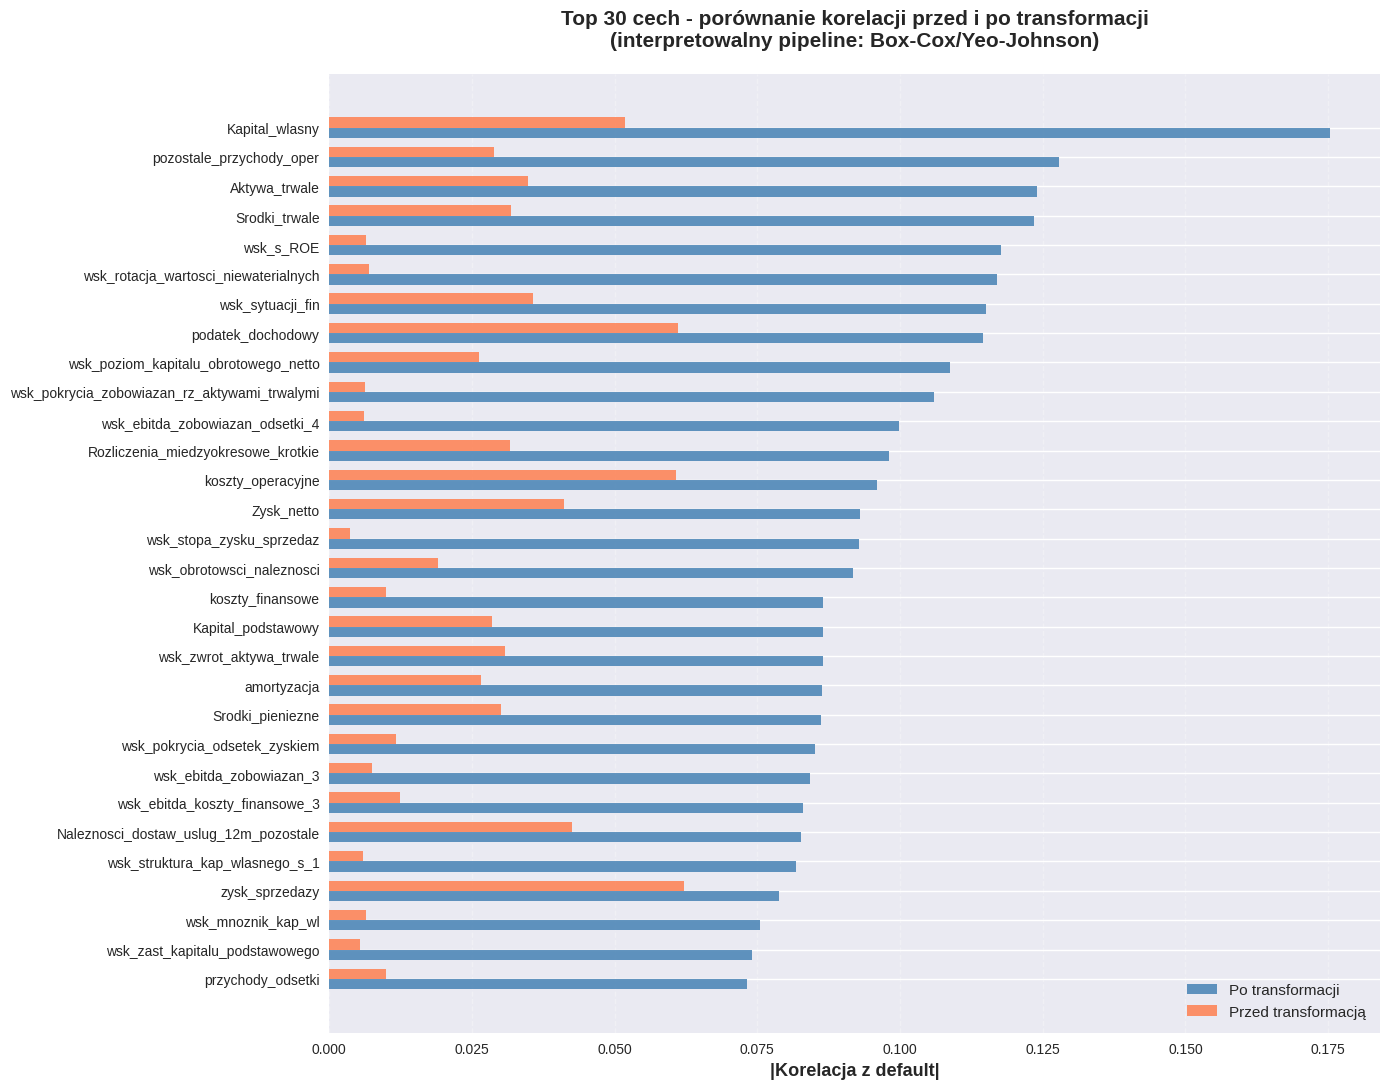


STATYSTYKI PORÓWNAWCZE (dla wspólnych cech)
Średnia |r| przed transformacją: 0.0184
Średnia |r| po transformacji:    0.0602
Poprawa korelacji:               +226.93%

Liczba cech, które się poprawiły: 65
Liczba cech, które się pogorszyły: 12


In [13]:
# Dane przed transformacją (tylko numeryczne)
X_train_before = X_train.select_dtypes(include='number')

# Korelacje
corr_before = X_train_before.corrwith(y_train).abs().sort_values(ascending=False)
corr_after = X_train_transformed.corrwith(y_train).abs().sort_values(ascending=False)

# Wspólne cechy (te które nie zostały usunięte)
common_features = list(set(corr_before.index) & set(corr_after.index))
corr_comparison = pd.DataFrame({
    'przed': corr_before[common_features],
    'po': corr_after[common_features]
}).sort_values('po', ascending=False)

# Wykres top 30
top_30_comparison = corr_comparison.head(30)

fig, ax = plt.subplots(figsize=(14, 11))
x = np.arange(len(top_30_comparison))
width = 0.35

ax.barh(x + width/2, top_30_comparison['po'], width, label='Po transformacji', color='steelblue', alpha=0.85)
ax.barh(x - width/2, top_30_comparison['przed'], width, label='Przed transformacją', color='coral', alpha=0.85)

ax.set_yticks(x)
ax.set_yticklabels(top_30_comparison.index)
ax.set_xlabel('|Korelacja z default|', fontsize=13, fontweight='bold')
ax.set_title('Top 30 cech - porównanie korelacji przed i po transformacji\n(interpretowalny pipeline: Box-Cox/Yeo-Johnson)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("STATYSTYKI PORÓWNAWCZE (dla wspólnych cech)")
print("="*60)
print(f"Średnia |r| przed transformacją: {corr_comparison['przed'].mean():.4f}")
print(f"Średnia |r| po transformacji:    {corr_comparison['po'].mean():.4f}")
improvement = ((corr_comparison['po'].mean() / corr_comparison['przed'].mean() - 1) * 100)
print(f"Poprawa korelacji:               {improvement:+.2f}%")
print(f"\nLiczba cech, które się poprawiły: {(corr_comparison['po'] > corr_comparison['przed']).sum()}")
print(f"Liczba cech, które się pogorszyły: {(corr_comparison['po'] < corr_comparison['przed']).sum()}")

### Rozkład skośności przed i po transformacji

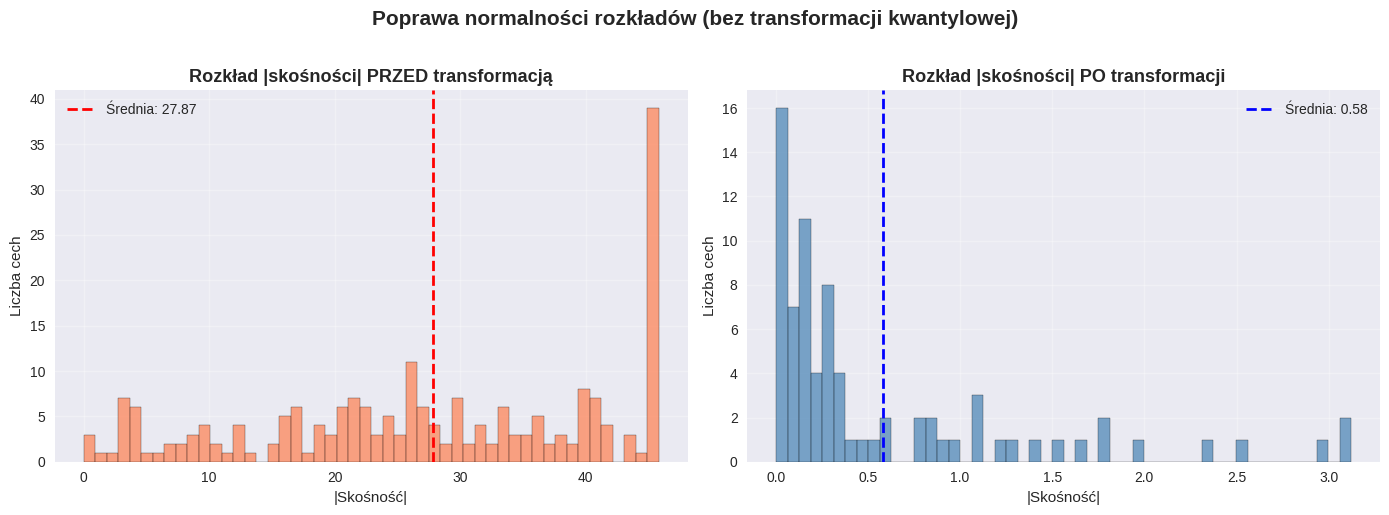


Statystyki |skośności|:
  PRZED: średnia = 27.874, mediana = 27.541, max = 45.826
  PO:    średnia = 0.580, mediana = 0.252, max = 3.123

  Redukcja średniej skośności: 97.9%


In [14]:
# Obliczenie skośności
skew_before = X_train_before.skew().abs()
skew_after = X_train_transformed.skew().abs()

# Histogram porównawczy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(skew_before, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0].axvline(skew_before.mean(), color='red', linestyle='--', linewidth=2, label=f'Średnia: {skew_before.mean():.2f}')
axes[0].set_title('Rozkład |skośności| PRZED transformacją', fontsize=13, fontweight='bold')
axes[0].set_xlabel('|Skośność|')
axes[0].set_ylabel('Liczba cech')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(skew_after, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axvline(skew_after.mean(), color='blue', linestyle='--', linewidth=2, label=f'Średnia: {skew_after.mean():.2f}')
axes[1].set_title('Rozkład |skośności| PO transformacji', fontsize=13, fontweight='bold')
axes[1].set_xlabel('|Skośność|')
axes[1].set_ylabel('Liczba cech')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle('Poprawa normalności rozkładów (bez transformacji kwantylowej)', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nStatystyki |skośności|:")
print(f"  PRZED: średnia = {skew_before.mean():.3f}, mediana = {skew_before.median():.3f}, max = {skew_before.max():.3f}")
print(f"  PO:    średnia = {skew_after.mean():.3f}, mediana = {skew_after.median():.3f}, max = {skew_after.max():.3f}")
print(f"\n  Redukcja średniej skośności: {(1 - skew_after.mean()/skew_before.mean())*100:.1f}%")

## Podsumowanie

In [15]:
print("="*70)
print("📊 PODSUMOWANIE PREPROCESSING")
print("="*70)

print(f"\n🔢 WYMIARY:")
print(f"  • Oryginał:     {X_train.shape}")
print(f"  • Po preprocessing: {X_train_transformed.shape}")
print(f"  • Redukcja:     {X_train.shape[1] - X_train_transformed.shape[1]} cech ({(1-X_train_transformed.shape[1]/X_train.shape[1])*100:.1f}%)")

print(f"\n🗑️  USUNIĘTE KOLUMNY:")
for category, cols in pipeline.columns_to_drop_.items():
    if category != 'all':
        print(f"  • {category:.<20} {len(cols):>3} kolumn")
print(f"  • {'Korelacje':.<20} {len(pipeline.high_corr_columns_to_drop_):>3} kolumn")

print(f"\n🔧 TRANSFORMACJE:")
method_counts = {}
for col in pipeline.final_columns_:
    method = pipeline.transformers_[col].method_used_
    method_counts[method] = method_counts.get(method, 0) + 1

for method, count in sorted(method_counts.items(), key=lambda x: x[1], reverse=True):
    pct = count / len(pipeline.final_columns_) * 100
    print(f"  • {method:.<20} {count:>3} cech ({pct:.1f}%)")

print(f"\n📈 JAKOŚĆ:")
print(f"  • Średnia |skośność|:  {X_train_transformed.skew().abs().mean():.4f}")
print(f"  • Max |skośność|:      {X_train_transformed.skew().abs().max():.4f}")
print(f"  • Redukcja skośności:  {(1 - skew_after.mean()/skew_before.mean())*100:.1f}%")

print(f"\n🎯 KORELACJA Z DEFAULT:")
print(f"  • |r| > 0.20:    {(final_correlations > 0.20).sum()} cech (bardzo silne)")
print(f"  • |r| > 0.15:    {(final_correlations > 0.15).sum()} cech (silne)")
print(f"  • |r| > 0.10:    {(final_correlations > 0.10).sum()} cech (umiarkowane)")
print(f"  • Najlepsza:     '{final_correlations.index[0]}' (|r| = {final_correlations.iloc[0]:.4f})")

print(f"\n✅ CECHY INTERPRETOWALNOŚCI:")
print(f"  ✓ Wszystkie transformacje są ODWRACALNE")
print(f"  ✓ Dostępna funkcja inverse_transform()")
print(f"  ✓ Zachowana monotoniczność (brak rank-based)")
print(f"  ✓ Gotowe do SHAP, LIME, PDP, ICE")

print("\n" + "="*70)
print("✅ PIPELINE GOTOWY DO MODELOWANIA!")
print("="*70)

📊 PODSUMOWANIE PREPROCESSING

🔢 WYMIARY:
  • Oryginał:     (2100, 219)
  • Po preprocessing: (2100, 103)
  • Redukcja:     116 cech (53.0%)

🗑️  USUNIĘTE KOLUMNY:
  • missing.............  10 kolumn
  • categorical.........   2 kolumn
  • low_variance........   6 kolumn
  • constant............   1 kolumn
  • Korelacje...........  98 kolumn

🔧 TRANSFORMACJE:
  • yeo-johnson.........  94 cech (91.3%)
  • box-cox.............   9 cech (8.7%)

📈 JAKOŚĆ:
  • Średnia |skośność|:  0.5803
  • Max |skośność|:      3.1226
  • Redukcja skośności:  97.9%

🎯 KORELACJA Z DEFAULT:


NameError: name 'final_correlations' is not defined

In [ ]:
print("="*70)
print("🎯 PODSUMOWANIE PORÓWNANIA MODELI")
print("="*70)

best_name, best_model, best_results = model_comparison.get_best_model('F1-Score')

print(f"\n📊 STATYSTYKI OGÓLNE:")
print(f"  • Liczba przetestowanych modeli: {len(results_df)}")
print(f"  • Rozmiar zbioru testowego: {len(y_test)}")
print(f"  • Klasa pozytywna (default=1): {y_test.sum()} ({y_test.sum()/len(y_test)*100:.1f}%)")
print(f"  • Klasa negatywna (default=0): {(~y_test.astype(bool)).sum()} ({(~y_test.astype(bool)).sum()/len(y_test)*100:.1f}%)")

print(f"\n🏆 NAJLEPSZY MODEL (wg F1-Score):")
print(f"  • Model: {best_name}")
print(f"  • F1-Score: {best_results['F1-Score']:.4f}")
print(f"  • Accuracy: {best_results['Accuracy']:.4f}")
print(f"  • Precision: {best_results['Precision']:.4f}")
print(f"  • Recall: {best_results['Recall']:.4f}")

print(f"\n📈 ZAKRES WYNIKÓW:")
print(f"  • F1-Score:  {results_df['F1-Score'].min():.4f} - {results_df['F1-Score'].max():.4f}")
print(f"  • Accuracy:  {results_df['Accuracy'].min():.4f} - {results_df['Accuracy'].max():.4f}")
print(f"  • Precision: {results_df['Precision'].min():.4f} - {results_df['Precision'].max():.4f}")
print(f"  • Recall:    {results_df['Recall'].min():.4f} - {results_df['Recall'].max():.4f}")

print(f"\n💡 REKOMENDACJE:")
print(f"  ✓ Model {best_name} osiąga najlepszy balans precision/recall")
print(f"  ✓ Wszystkie modele są INTERPRETOWALNE - gotowe do analizy SHAP/LIME")
print(f"  ✓ Pipeline z inverse_transform pozwala na pełną interpretowalność")

print(f"\n🔍 NASTĘPNE KROKI:")
print(f"  1. Analiza SHAP dla modelu {best_name}")
print(f"  2. Analiza najważniejszych cech")
print(f"  3. Partial Dependence Plots dla kluczowych predyktorów")
print(f"  4. Analiza przypadków False Positive/False Negative")

print("\n" + "="*70)
print("✅ ANALIZA MODELI ZAKOŃCZONA!")
print("="*70)

## Podsumowanie i rekomendacje

In [ ]:
# Pobranie najlepszego modelu
best_name, best_model, _ = model_comparison.get_best_model('F1-Score')

print("="*70)
print("💡 PRZYKŁAD UŻYCIA NAJLEPSZEGO MODELU")
print("="*70)
print(f"\nNajlepszy model: {best_name}\n")

# Przykładowa predykcja
sample_data = X_test_transformed.iloc[:3]
print("Predykcje na przykładowych danych:")
predictions = best_model.predict(sample_data)
print(f"Klasy: {predictions}")

try:
    probabilities = best_model.predict_proba(sample_data)
    print(f"\nPrawdopodobieństwa:")
    for i, (pred, proba) in enumerate(zip(predictions, probabilities)):
        print(f"  Rekord {i+1}: klasa={pred}, P(default=0)={proba[0]:.3f}, P(default=1)={proba[1]:.3f}")
except:
    print("  (model nie zwraca prawdopodobieństw)")

print(f"\n📋 Dostęp do modelu i wyników:")
print(f"  • Obiekt modelu: model_comparison.models['{best_name}']")
print(f"  • Wszystkie wyniki: model_comparison.results_df")
print(f"  • Metoda get_best_model(): zwraca (nazwa, model, wyniki)")

## Przykład użycia najlepszego modelu

In [ ]:
# Krzywe ROC
plt.figure(figsize=(10, 8))

for name, model in model_comparison.models.items():
    if name == 'RIPPER':
        continue  # RIPPER nie daje prawdopodobieństw
    
    try:
        y_proba = model.predict_proba(X_test_transformed)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.3f})')
    except Exception as e:
        print(f"⚠️  Nie można wykreślić ROC dla {name}: {e}")

# Linia losowego klasyfikatora
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold')
plt.title('Krzywe ROC - Porównanie Modeli', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("✅ Krzywe ROC wygenerowane")

## Krzywe ROC (jeśli dostępne prawdopodobieństwa)

Porównanie krzywych ROC dla modeli z dostępnymi prawdopodobieństwami predykcji.

In [ ]:
# Szczegółowa analiza predykcji
print("="*70)
print("🔍 SZCZEGÓŁOWA ANALIZA PREDYKCJI")
print("="*70)

# DataFrame z komponentami macierzy pomyłek
cm_details = results_df[['Model', 'TN', 'FP', 'FN', 'TP']].copy()
cm_details['Total'] = cm_details['TN'] + cm_details['FP'] + cm_details['FN'] + cm_details['TP']
cm_details['TPR (Sensitivity)'] = cm_details['TP'] / (cm_details['TP'] + cm_details['FN'])
cm_details['TNR (Specificity)'] = cm_details['TN'] / (cm_details['TN'] + cm_details['FP'])
cm_details['FPR (Fall-out)'] = cm_details['FP'] / (cm_details['FP'] + cm_details['TN'])
cm_details['FNR (Miss Rate)'] = cm_details['FN'] / (cm_details['FN'] + cm_details['TP'])

print("\n📋 Komponenty Macierzy Pomyłek:")
print(cm_details[['Model', 'TN', 'FP', 'FN', 'TP']].to_string(index=False))

print("\n📊 Dodatkowe Wskaźniki:")
print(cm_details[['Model', 'TPR (Sensitivity)', 'TNR (Specificity)', 'FPR (Fall-out)', 'FNR (Miss Rate)']].to_string(index=False))

# Wizualizacja komponentów
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(results_df))
width = 0.2

bars1 = ax.bar(x - 1.5*width, results_df['TN'], width, label='TN (True Negative)', color='#2ecc71', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, results_df['FP'], width, label='FP (False Positive)', color='#e74c3c', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, results_df['FN'], width, label='FN (False Negative)', color='#f39c12', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, results_df['TP'], width, label='TP (True Positive)', color='#3498db', alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Liczba przypadków', fontsize=12, fontweight='bold')
ax.set_title('Rozkład Predykcji: True/False Positives/Negatives', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✅ Analiza szczegółowa zakończona")

## Analiza szczegółowa: True/False Positives/Negatives

In [ ]:
# Macierze pomyłek dla wszystkich modeli
n_models = len(results_df)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, (_, row) in enumerate(results_df.iterrows()):
    ax = axes[idx]
    cm = row['Confusion Matrix']
    
    # Heatmapa
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar=False, square=True, linewidths=2, linecolor='black',
                annot_kws={'size': 14, 'weight': 'bold'})
    
    ax.set_title(f"{row['Model']}\nF1={row['F1-Score']:.3f}, Acc={row['Accuracy']:.3f}", 
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)
    ax.set_xticklabels(['No Default (0)', 'Default (1)'])
    ax.set_yticklabels(['No Default (0)', 'Default (1)'])

# Ukrycie pustych subplotów
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Macierze Pomyłek (Confusion Matrices) - Wszystkie Modele', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✅ Macierze pomyłek wygenerowane")

## Macierze pomyłek (Confusion Matrices)

Wizualizacja macierzy pomyłek dla wszystkich modeli.

In [ ]:
# Wykres porównawczy metryk
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    
    # Sortowanie dla każdej metryki
    data = results_df.sort_values(metric, ascending=True)
    
    bars = ax.barh(data['Model'], data[metric], color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} - Porównanie Modeli', fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1.0)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Dodanie wartości na słupkach
    for i, (bar, value) in enumerate(zip(bars, data[metric])):
        ax.text(value + 0.01, i, f'{value:.3f}', va='center', fontsize=10, fontweight='bold')

plt.suptitle('Porównanie Modeli Interpretowalnych - Metryki Klasyfikacji', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✅ Wykres metryk wygenerowany")

## Wizualizacja porównania metryk

In [ ]:
# Wyświetlenie podsumowania
model_comparison.print_summary()

## Tabela porównawcza metryk

In [ ]:
# Inicjalizacja klasy porównania
model_comparison = ModelComparison()

# Trening wszystkich modeli
model_comparison.train_models(X_train_transformed, y_train)

# Ewaluacja na zbiorze testowym
results_df = model_comparison.evaluate_models(X_test_transformed, y_test)

## Trening i ewaluacja modeli

Używamy klasy ModelComparison do wytrenowania i oceny wszystkich modeli.

In [ ]:
class ModelComparison:
    """
    Klasa do trenowania, testowania i porównywania modeli klasyfikacyjnych.
    
    Obsługuje:
    - Regresję Logistyczną
    - Drzewo Decyzyjne
    - Naive Bayes
    - EBM (Explainable Boosting Machine)
    - GAM (Generalized Additive Model)
    - RIPPER (Rule Induction)
    """
    
    def __init__(self):
        self.models = {}
        self.training_times = {}
        self.results_df = None
        self.results = []
        
    def _check_libraries(self):
        """Sprawdza dostępność zaawansowanych bibliotek."""
        availability = {
            'EBM': False,
            'GAM': False,
            'RIPPER': False
        }
        
        try:
            from interpret.glassbox import ExplainableBoostingClassifier
            availability['EBM'] = True
        except ImportError:
            pass
            
        try:
            from pygam import LogisticGAM
            availability['GAM'] = True
        except ImportError:
            pass
            
        try:
            import wittgenstein as lw
            availability['RIPPER'] = True
        except ImportError:
            pass
            
        return availability
    
    def train_models(self, X_train, y_train, verbose=True):
        """
        Trenuje wszystkie dostępne modele.
        
        Parametry:
        ----------
        X_train : pd.DataFrame
            Dane treningowe (po transformacji)
        y_train : pd.Series
            Etykiety treningowe
        verbose : bool
            Czy wyświetlać postęp treningu
        """
        if verbose:
            print("="*70)
            print("🤖 TRENING MODELI INTERPRETOWALNYCH")
            print("="*70)
        
        availability = self._check_libraries()
        
        # 1. Regresja Logistyczna
        if verbose:
            print("\n[1/6] Regresja Logistyczna...")
        start = time.time()
        lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
        lr.fit(X_train, y_train)
        self.models['Logistic Regression'] = lr
        self.training_times['Logistic Regression'] = time.time() - start
        if verbose:
            print(f"   ✓ Wytrenowana w {self.training_times['Logistic Regression']:.2f}s")
        
        # 2. Drzewo Decyzyjne
        if verbose:
            print("\n[2/6] Drzewo Decyzyjne...")
        start = time.time()
        dt = DecisionTreeClassifier(
            max_depth=10, 
            min_samples_split=50,
            min_samples_leaf=20,
            random_state=42,
            class_weight='balanced'
        )
        dt.fit(X_train, y_train)
        self.models['Decision Tree'] = dt
        self.training_times['Decision Tree'] = time.time() - start
        if verbose:
            print(f"   ✓ Wytrenowane w {self.training_times['Decision Tree']:.2f}s")
            print(f"   • Głębokość: {dt.get_depth()}, Liście: {dt.get_n_leaves()}")
        
        # 3. Naive Bayes
        if verbose:
            print("\n[3/6] Naive Bayes (Gaussian)...")
        start = time.time()
        nb = GaussianNB()
        nb.fit(X_train, y_train)
        self.models['Naive Bayes'] = nb
        self.training_times['Naive Bayes'] = time.time() - start
        if verbose:
            print(f"   ✓ Wytrenowany w {self.training_times['Naive Bayes']:.2f}s")
        
        # 4. EBM
        if availability['EBM']:
            if verbose:
                print("\n[4/6] EBM (Explainable Boosting Machine)...")
            start = time.time()
            from interpret.glassbox import ExplainableBoostingClassifier
            ebm = ExplainableBoostingClassifier(
                random_state=42,
                n_jobs=-1,
                max_bins=256,
                interactions=10
            )
            ebm.fit(X_train, y_train)
            self.models['EBM'] = ebm
            self.training_times['EBM'] = time.time() - start
            if verbose:
                print(f"   ✓ Wytrenowany w {self.training_times['EBM']:.2f}s")
        else:
            if verbose:
                print("\n[4/6] EBM - POMINIĘTY (brak biblioteki interpret)")
        
        # 5. GAM
        if availability['GAM']:
            if verbose:
                print("\n[5/6] GAM (Generalized Additive Model)...")
            start = time.time()
            from pygam import LogisticGAM
            gam = LogisticGAM()
            try:
                gam.gridsearch(X_train.values, y_train.values)
                self.models['GAM'] = gam
                self.training_times['GAM'] = time.time() - start
                if verbose:
                    print(f"   ✓ Wytrenowany w {self.training_times['GAM']:.2f}s")
            except Exception as e:
                if verbose:
                    print(f"   ⚠️  Błąd treningu GAM: {e}")
        else:
            if verbose:
                print("\n[5/6] GAM - POMINIĘTY (brak biblioteki pygam)")
        
        # 6. RIPPER
        if availability['RIPPER']:
            if verbose:
                print("\n[6/6] RIPPER (Rule Induction)...")
            start = time.time()
            import wittgenstein as lw
            ripper = lw.RIPPER()
            try:
                X_train_ripper = X_train.copy()
                X_train_ripper['default'] = y_train.values
                ripper.fit(X_train_ripper, class_feat='default', pos_class=1)
                self.models['RIPPER'] = ripper
                self.training_times['RIPPER'] = time.time() - start
                if verbose:
                    print(f"   ✓ Wytrenowany w {self.training_times['RIPPER']:.2f}s")
                    print(f"   • Liczba reguł: {len(ripper.ruleset_)}")
            except Exception as e:
                if verbose:
                    print(f"   ⚠️  Błąd treningu RIPPER: {e}")
        else:
            if verbose:
                print("\n[6/6] RIPPER - POMINIĘTY (brak biblioteki wittgenstein)")
        
        if verbose:
            print("\n" + "="*70)
            print(f"✅ WYTRENOWANO {len(self.models)} MODELI")
            print("="*70)
        
        return self
    
    def evaluate_models(self, X_test, y_test, verbose=True):
        """
        Ocenia wszystkie wytrenowane modele na zbiorze testowym.
        
        Parametry:
        ----------
        X_test : pd.DataFrame
            Dane testowe (po transformacji)
        y_test : pd.Series
            Etykiety testowe
        verbose : bool
            Czy wyświetlać postęp
        
        Zwraca:
        --------
        pd.DataFrame : DataFrame z wynikami
        """
        if verbose:
            print("="*70)
            print("📊 OBLICZANIE METRYK NA ZBIORZE TESTOWYM")
            print("="*70)
        
        self.results = []
        
        for name, model in self.models.items():
            if verbose:
                print(f"\n{name}...")
            
            # Predykcje
            if name == 'RIPPER':
                X_test_ripper = X_test.copy()
                y_pred = model.predict(X_test_ripper)
                y_pred = np.array([1 if p == 1 else 0 for p in y_pred])
                y_proba = None
            else:
                y_pred = model.predict(X_test)
                try:
                    y_proba = model.predict_proba(X_test)[:, 1]
                except:
                    y_proba = None
            
            # Metryki
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            # AUC
            if y_proba is not None:
                try:
                    auc = roc_auc_score(y_test, y_proba)
                except:
                    auc = None
            else:
                auc = None
            
            # Macierz pomyłek
            cm = confusion_matrix(y_test, y_pred)
            tn, fp, fn, tp = cm.ravel()
            
            self.results.append({
                'Model': name,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1-Score': f1,
                'ROC-AUC': auc,
                'TN': tn,
                'FP': fp,
                'FN': fn,
                'TP': tp,
                'Training Time (s)': self.training_times[name],
                'Confusion Matrix': cm
            })
            
            if verbose:
                print(f"   ✓ Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
        
        # Tworzenie DataFrame
        self.results_df = pd.DataFrame(self.results)
        self.results_df = self.results_df.sort_values('F1-Score', ascending=False)
        
        if verbose:
            print("\n" + "="*70)
            print("✅ METRYKI OBLICZONE")
            print("="*70)
        
        return self.results_df
    
    def print_summary(self):
        """Wyświetla podsumowanie wyników."""
        if self.results_df is None:
            print("⚠️  Najpierw uruchom evaluate_models()")
            return
        
        print("="*70)
        print("📊 PORÓWNANIE MODELI - METRYKI")
        print("="*70)
        print()
        
        metrics_display = self.results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].copy()
        print(metrics_display.to_string(index=False))
        
        print("\n" + "="*70)
        print("⏱️  CZASY TRENINGU")
        print("="*70)
        print()
        time_display = self.results_df[['Model', 'Training Time (s)']].copy()
        print(time_display.to_string(index=False))
        
        print("\n" + "="*70)
        print("🎯 NAJLEPSZE MODELE")
        print("="*70)
        print(f"\n🥇 Najwyższy F1-Score:  {self.results_df.iloc[0]['Model']} ({self.results_df.iloc[0]['F1-Score']:.4f})")
        print(f"🥈 Najwyższa Accuracy:  {self.results_df.loc[self.results_df['Accuracy'].idxmax()]['Model']} ({self.results_df['Accuracy'].max():.4f})")
        print(f"🥉 Najwyższy Recall:    {self.results_df.loc[self.results_df['Recall'].idxmax()]['Model']} ({self.results_df['Recall'].max():.4f})")
        print(f"⚡ Najszybszy trening:  {self.results_df.loc[self.results_df['Training Time (s)'].idxmin()]['Model']} ({self.results_df['Training Time (s)'].min():.2f}s)")
    
    def get_best_model(self, metric='F1-Score'):
        """
        Zwraca najlepszy model według wybranej metryki.
        
        Parametry:
        ----------
        metric : str
            Metryka do optymalizacji ('F1-Score', 'Accuracy', 'Precision', 'Recall')
        
        Zwraca:
        --------
        tuple : (nazwa_modelu, obiekt_modelu, wyniki)
        """
        if self.results_df is None:
            raise ValueError("Najpierw uruchom evaluate_models()")
        
        best_idx = self.results_df[metric].idxmax()
        best_name = self.results_df.loc[best_idx, 'Model']
        best_model = self.models[best_name]
        best_results = self.results_df.loc[best_idx]
        
        return best_name, best_model, best_results

print("✅ Klasa ModelComparison zdefiniowana")

## Klasa ModelComparison

Klasa do trenowania, testowania i porównywania modeli interpretowalnych.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import cross_val_score
import time

# Modele interpretowalne zaawansowane
try:
    from interpret.glassbox import ExplainableBoostingClassifier
    EBM_AVAILABLE = True
except ImportError:
    print("⚠️  interpret not installed. Install: pip install interpret")
    EBM_AVAILABLE = False

try:
    from pygam import LogisticGAM, s
    GAM_AVAILABLE = True
except ImportError:
    print("⚠️  pygam not installed. Install: pip install pygam")
    GAM_AVAILABLE = False

try:
    import wittgenstein as lw
    RIPPER_AVAILABLE = True
except ImportError:
    print("⚠️  wittgenstein not installed. Install: pip install wittgenstein")
    RIPPER_AVAILABLE = False

print("✅ Biblioteki załadowane")
print(f"   • EBM dostępny: {EBM_AVAILABLE}")
print(f"   • GAM dostępny: {GAM_AVAILABLE}")
print(f"   • RIPPER dostępny: {RIPPER_AVAILABLE}")

## Import dodatkowych bibliotek

# Modelowanie i Porównanie Interpretowalnych Modeli

W tej sekcji trenujemy i porównujemy modele zoptymalizowane pod interpretowalność.